# Deep nodes search

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import heapq

from sklearn.preprocessing import StandardScaler

from scipy.special import betainc

from concurrent.futures import ProcessPoolExecutor, as_completed

In [2]:
test = False

In [3]:
path_adj_mat_pearson = '/home/thomas/Documents/git/medulloblastoma_cavalli_kaggle/data/network/adj_mat_pearson.csv'
path_cross_tt = '/home/thomas/Documents/git/medulloblastoma_cavalli_kaggle/data/dge/cross_tt_genes_wnt_vs_all.csv'

In [4]:
adj_mat_pearson = pd.read_csv(path_adj_mat_pearson,index_col=0)
cross_tt=pd.read_csv(path_cross_tt,index_col=0)

In [5]:
adj_mat_pearson

,IFNA10,OR13C2,OR5M1,OR8H3,SAA1,OR5T1,IFNA7,OR8B3,OR5H1,CAPZA3,...,RSPH6A,CNTN3,CYP2S1,TRIM61,MRPL22,DEF6,ANPEP,FCN3,FAM170B,SPX
IFNA10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OR13C2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OR5M1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OR8H3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.710293,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SAA1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DEF6,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.000000,0.0,-0.0,...,-0.0,0.0,0.0,-0.0,0.706739,0.000000,0.771348,0.795688,0.805508,0.827444
ANPEP,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.000000,0.0,-0.0,...,0.0,0.0,0.0,-0.0,0.000000,0.771348,0.000000,0.000000,0.720271,0.848847
FCN3,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.000000,0.0,-0.0,...,-0.0,0.0,0.0,-0.0,0.000000,0.795688,0.000000,0.000000,0.000000,0.707941
FAM170B,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.000000,0.0,-0.0,...,-0.0,0.0,0.0,-0.0,0.000000,0.805508,0.720271,0.000000,0.000000,0.828392


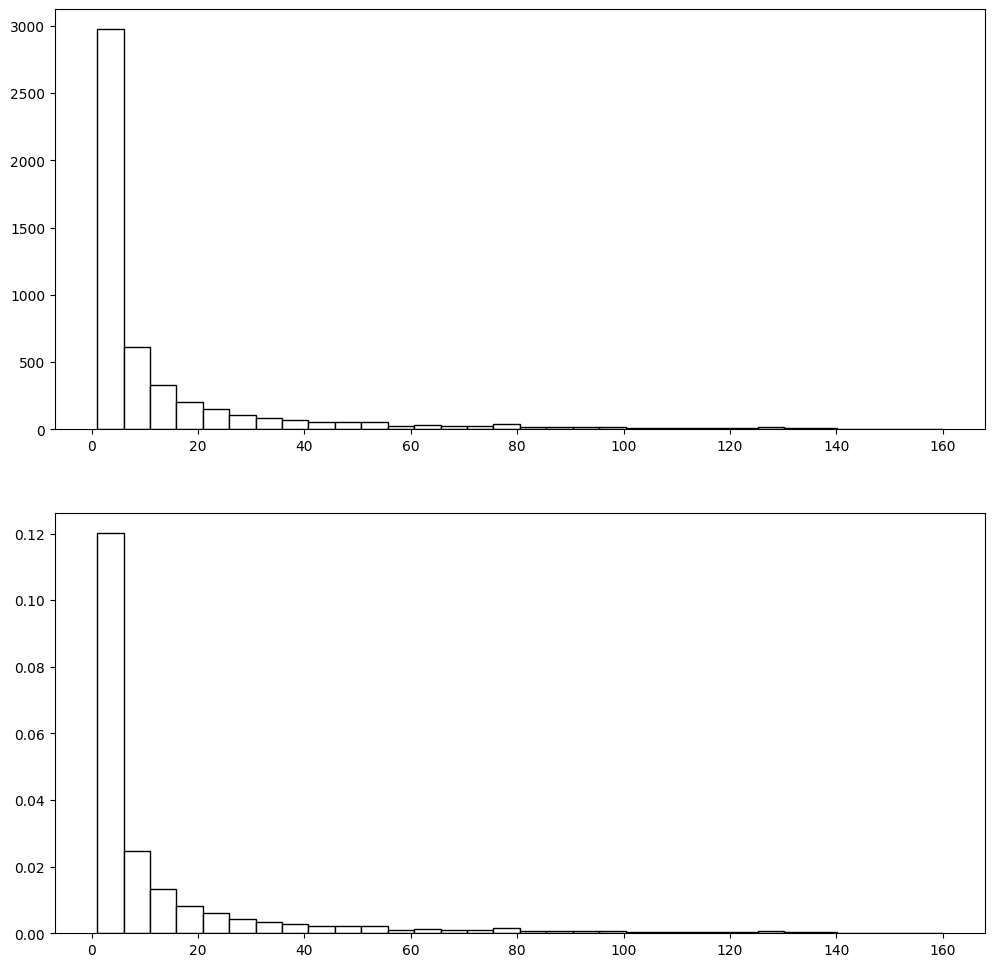

In [6]:
adj_mat_pearson_edge = np.where(adj_mat_pearson!=0,1,0)

#plot degrees
fig, (ax1, ax2) = plt.subplots(2,1,figsize = (12, 12))
ax1.hist(adj_mat_pearson_edge.sum(axis=0),bins=32,edgecolor='black',color='white',density=False)
ax2.hist(adj_mat_pearson_edge.sum(axis=0),bins=32,edgecolor='black',color='white',density=True)
plt.show()

In [7]:
genes_associated_wnt=cross_tt[cross_tt['all']==1].index.tolist()
cross_genes=set(genes_associated_wnt).intersection(set(adj_mat_pearson.columns.tolist()))

In [8]:
adj_mat_pearson_edge=pd.DataFrame(data=adj_mat_pearson_edge,index=adj_mat_pearson.columns, columns=adj_mat_pearson.columns)
adj_mat_pearson_edge[list(cross_genes)].sum(axis=0)

IPCEF1     5
JPH1       2
SLC46A2    1
SLA2       3
SULT2B1    1
dtype: int64

In [9]:
idx_edge_10 = np.where(adj_mat_pearson_edge.sum(axis=0) <= 10)[0]
idx_edge_5 = np.where(adj_mat_pearson_edge.sum(axis=0) <= 5)[0]
adj_mat_pearson_edge_10=adj_mat_pearson_edge.iloc[idx_edge_10,idx_edge_10]
adj_mat_pearson_edge_5=adj_mat_pearson_edge.iloc[idx_edge_5,idx_edge_5]
#adj_mat_pearson_edge_10=adj_mat_pearson_edge_10.loc[adj_mat_pearson_edge_10.columns.tolist(),:]

In [10]:
adj_mat_pearson_edge_5.shape

(2975, 2975)

In [11]:
def get_neighbor(adj_mat,gene,dict_neighbor_parent=None):

    if dict_neighbor_parent is None:
        dict_neighbor_parent = {}

    genes = adj_mat.columns.tolist()
    
    
    dict_neighbor_parent[gene]=[genes[i]for i in np.where(adj_mat.loc[gene]!=0)[0]]
    return dict_neighbor_parent

In [12]:
#test_dict = get_neighbor(adj_mat=adj_mat_pearson_edge_5, gene='SLA2')

In [13]:
def add_weights_to_adj_matrix(adj_mat):

    weights = np.array(adj_mat.sum(axis=1))

    adj_mat_triu = np.triu(adj_mat,k=1)

    weights_array = adj_mat_triu * weights
    weights_array += weights_array.T
    weights_array = np.where(weights_array==0,1,weights_array)

    adj_mat_weights = adj_mat / weights_array
    adj_mat_weights/=adj_mat_weights.max(axis=1)
    adj_mat_weights = adj_mat - adj_mat_weights
    
    return adj_mat_weights

In [14]:
adj_mat_weights = add_weights_to_adj_matrix(adj_mat_pearson_edge)

In [15]:
def dijkstra_optim(adj_mat,start,end,depth_lim,early_path=False):

    n = len(adj_mat)
    dist = [np.inf] * n
    dist[start] = 0
    previous = [-1] * n
    priority_queue = [(0, start, 0)]
    visited = [False] * n # max depth/nodes visited 

    while priority_queue:
        current_dist, current_node, current_depth = heapq.heappop(priority_queue)

        if current_depth > depth_lim:
            continue

        if current_node == end: 
            path = []
            while current_node !=-1:
                path.append(current_node)
                current_node = previous[current_node]
            path.reverse()

            if early_path:
                return dist[end], path

        if visited[current_node]:
            continue
            
        visited[current_node] = True

        for neighbor in range(n):
            weights = adj_mat[current_node][neighbor]
            print(weights)
            if weights != 0 and not visited[neighbor]: 
                new_dist = current_dist + weights
                print('new dist: ',new_dist)
                print('current dist: ',current_dist)
                print('dist:',dist[neighbor])
                if new_dist < dist[neighbor]:
                    print('test2')
                    dist[neighbor] = new_dist
                    previous[neighbor] = current_node
                    heapq.heappush(priority_queue, (new_dist, neighbor, current_depth + 1))
                    
    
    
    #return np.inf, None

In [16]:
matrix = [
    [0, 1, 0, 3],
    [1, 0, 4, 0],
    [0, 4, 0, 2],
    [3, 0, 2, 0]
]


In [17]:
if test:
    start_node = 0
    end_node = 2
    depth_limit = 10
    early_stop = False  # On cherche le chemin le plus court
    
    distance, path = dijkstra_optim(matrix, start_node, end_node, depth_limit, early_stop)
    #print(f"Distance minimale : {distance}")
    #print(f"Chemin emprunté : {path}")


In [18]:
import heapq

def dijkstra_with_depth_limit(matrix, start, end, depth_limit, early_stop=False):
    n = len(matrix)  # Nombre de nœuds dans le graphe
    distances = [float('inf')] * n  # Initialisation des distances à l'infini
    distances[start] = 0  # La distance du nœud de départ est 0
    previous = [-1] * n  # Pour reconstruire le chemin
    priority_queue = [(0, start, 0)]  # (distance cumulée, nœud, profondeur actuelle)

    while priority_queue:
        # Extraire le nœud avec la distance cumulée minimale
        current_distance, current_node, current_depth = heapq.heappop(priority_queue)

        # Si la profondeur limite est dépassée, on ignore ce nœud
        if current_depth > depth_limit:
            continue

        # Si on atteint le nœud cible
        if current_node == end:
            # Reconstruire le chemin
            path = []
            while current_node != -1:
                path.append(current_node)
                current_node = previous[current_node]
            path.reverse()
            
            # Arrêt anticipé si activé
            if early_stop:
                return distances[end], path

        # Explorer les voisins
        for neighbor in range(n):
            weight = matrix[current_node][neighbor]
            if weight > 0:  # S'il y a une arête
                new_distance = current_distance + weight
                # Si un chemin plus court est trouvé
                if new_distance < distances[neighbor]:
                    distances[neighbor] = new_distance
                    previous[neighbor] = current_node
                    # Ajouter le voisin à la file avec une profondeur augmentée
                    heapq.heappush(priority_queue, (new_distance, neighbor, current_depth + 1))

    # Si aucun chemin valide n'est trouvé
    return float('inf'), None


In [19]:
matrix = [
    [0, 1, 0, 3],
    [1, 0, 4, 0],
    [0, 4, 0, 2],
    [3, 0, 2, 0]
]

start_node = 0
end_node = 2
depth_limit = 2


In [20]:
distance, path = dijkstra_with_depth_limit(matrix, start_node, end_node, depth_limit, early_stop=False)
print(f"Distance minimale : {distance}")
print(f"Chemin emprunté : {path}")


Distance minimale : inf
Chemin emprunté : None
